<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/%5BAIDL2025_26%5D_L05___transformer1_(todo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build your own Transformer

Created by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) for the [Postgraduate Course in Artificial Intelligence with Deep Learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) ([UPC School](https://www.talent.upc.edu/ing/), 2021).

Updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) (2024).

In this lab we will learn about the [Transformer](https://papers.nips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html), a popular architecture that revolutionized Deep Learning a few years ago.

This architecture was firstly designed for Machine Translation. In this field, Recurrent Neural Networks (e.g. LSTM) had been the state-of-the-art since [the introduction of the Attention mechanism](https://arxiv.org/abs/1409.0473) in 2015. The Transformer surpassed them by introducing a key idea: getting rid of any recurrence and mainly using the **(Self-)Attention** mechanism, as the title of the paper states: [Attention is All you Need](https://papers.nips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html).

Actually, Transformer-based architectures are used in many fields beyond Machine Translation. First, many models arised for other text-related tasks (e.g. [BERT](https://arxiv.org/abs/1810.04805) or [GPT-3](https://arxiv.org/abs/2005.14165)), but now they're also used in other fields, like [Speech processing](https://proceedings.neurips.cc/paper/2020/hash/92d1e1eb1cd6f9fba3227870bb6d7f07-Abstract.html) and [Computer Vision](https://arxiv.org/abs/2010.11929).

Throughout this notebook, we will build our own Transformer, and you'll understand module by module how this architecture works. Once it's finished, we will train it with a dummy dataset and we will try to interpret the results.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import math
import time
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

## Transformer architecture

Here we go!

In the left part of the figure below, you can see the Transformer architecture. Take a look at it carefully to get used to all this new terminology.

You can also see a breakdown of the most important module in the Transfomer: the Multi-Head Attention, which is based on the Scaled-Dot Product Attention.

<p align="center">
<img src="https://lilianweng.github.io/lil-log/assets/images/transformer.png" width="1000px" alt="Zoom in to the Transformer"/>
</p>

Don't panic! ;) We will start from the most simple structure and we will build upon it, little by little. Let's start with the Scaled Dot-Product Attention!

### Scaled Dot-Product Attention

The first key idea to understand how the Transformer works is the Scaled Dot Product Attention (we will call it SDPA from now on).

<p align="center">
<img src="https://paperswithcode.com/media/methods/SCALDE.png" height="300px" alt="Scaled Dot-Product Attention"/>
</p>

This is the equation:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

You are probably trying to figure out what $Q$, $K$ and $V$ are, right? They are the queries, the keys and the values. A good example to understand these concepts is the one given by [@dontloo](https://stats.stackexchange.com/users/95569/dontloo) in StackExchange

>[...]
>
>The key/value/query concepts come from retrieval systems. For example, when you type a query to search for some video on Youtube, the search engine will map your query against a set of keys (video title, description, etc.) associated with candidate videos in the database, then present you the best matched videos (values).
>
>The attention operation turns out can be thought of as a retrieval process as well, so the key/value/query concepts also apply here.
>
>[...]
>
>[[Read the full answer]](https://stats.stackexchange.com/a/424127)

This keys/values/query can represent tokens in a sentence. Furthermore, the attention function can be computed on a set of queries simultaneously. Hence, they are packed together into a matrix $Q$, like the keys ($K$) and the values ($V$). Take into account that you need the same amount of keys and values, but the number of queries can differ.

Also, why is the scaling needed? Well, it turns out that for high-dimensional keys (large $d_k$) the dot-product grow large in magnitude, hurting the gradients.

Finally, note that in the figure there is a module called "Module (opt.)" which doesn't appear in the equation. This allows us to control which values can the queries "attend" to. This will be useful, for example, to avoid attention to padding tokens, which we use to batch sentences of different length.

In [2]:
def scaled_dot_product(q, k, v, attn_mask=None):
    """ Computes the Scaled Dot-Product Attention

    Args:
        q (torch.FloatTensor):  Query Tensor   (... x T_q x d_q)
        k (torch.FloatTensor):  Key Tensor     (... x T_k x d_k)
        v (torch.FloatTensor):  Value Tensor   (... x T_v x d_v)
        attn_mask (torch.BoolTensor): Attention mask (... x T_q x T_k)

    Returns:
        torch.FloatTensor: Result of the SDPA  (... x T_q x d_v)
        torch.FloatTensor: Attention map       (... x T_q x T_k)

    """
    assert q.size(-1) == k.size(-1), "Query and Key dimensions must coincide"

    # Matrix multiplication of the queries and the keys (use torch.matmul)
    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    # Scale attn_logits (see the SDPA formula, d_k is the last dim of k)
    attn_logits = attn_logits / math.sqrt(k.size(-1))

    if attn_mask is not None:
        attn_logits = attn_logits.masked_fill(~attn_mask, -float("inf"))

    # Compute the attention weights (see the SDPA formula, use dim=-1)
    attn_weights = F.softmax(attn_logits, dim=-1)

    output = torch.matmul(attn_weights, v)

    return output, attn_weights

In [3]:
def plot_attention(attn_weights, queries, keys, xtitle="Keys", ytitle="Queries"):
    """ Plots the attention map

    Args:
        att (torch.FloatTensor): Attention map (T_q x T_k)
        queries (List[str]): Query Tensor
        keys (List[str]): Key Tensor
    """

    sns.set(rc={'figure.figsize':(12, 8)})
    ax = sns.heatmap(
        attn_weights.detach().cpu(),
        linewidth=0.5,
        xticklabels=keys,
        yticklabels=queries,
        cmap="Blues")

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

    plt.show()

Let's create some random queries, keys and values, with the following dimensions:
- $T_Q=5$
- $T_K=T_V=8$
- $d_Q=d_K=d_V=4$

We will use them to test our SDPA function.

In [4]:
q = torch.randn(5, 4)
k = torch.randn(8, 4)
v = torch.randn(8, 4)

Output:
tensor([[ 1.5008,  0.4767, -1.0747, -0.4886],
        [-0.1684,  0.3956, -0.1350, -0.0119],
        [-0.4623,  0.5124, -0.4455,  0.0919],
        [ 0.9522,  0.3551, -0.7670, -0.3439],
        [ 1.1914, -0.0205, -0.3149, -0.3944]])
torch.Size([5, 4])

Attention weights:
tensor([[0.0402, 0.0389, 0.0484, 0.1171, 0.0906, 0.1028, 0.0500, 0.5120],
        [0.2087, 0.0825, 0.2318, 0.1173, 0.0948, 0.0580, 0.1716, 0.0352],
        [0.3074, 0.0653, 0.1753, 0.0239, 0.0243, 0.0762, 0.2734, 0.0543],
        [0.0873, 0.0693, 0.0917, 0.0860, 0.1048, 0.1342, 0.0977, 0.3290],
        [0.0294, 0.0940, 0.0389, 0.2921, 0.1697, 0.1105, 0.0354, 0.2301]])
torch.Size([5, 8])



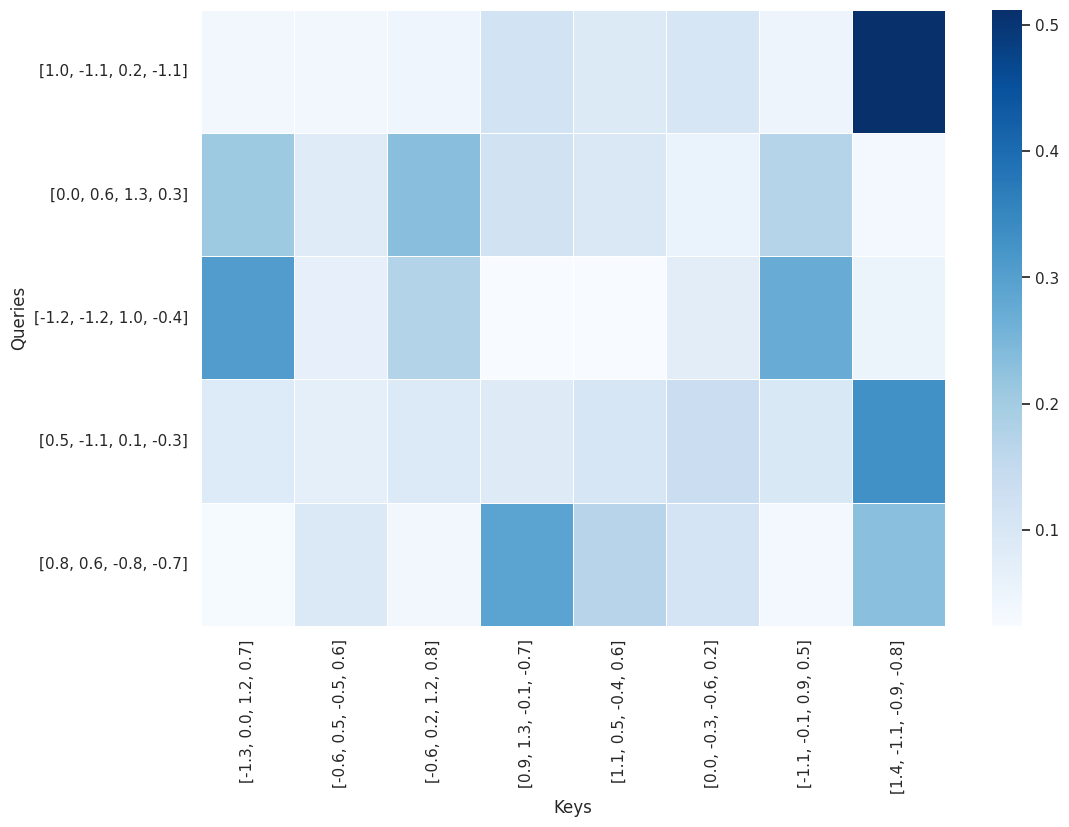

In [5]:
output, attn_weights = scaled_dot_product(q, k, v)

print(f"Output:\n{output}\n{output.shape}\n")
print(f"Attention weights:\n{attn_weights}\n{attn_weights.shape}\n")

plot_attention(
    attn_weights,
    [str([round(float(q__), 1) for q__ in q_]) for q_ in q],
    [str([round(float(k__), 1) for k__ in k_]) for k_ in k],
)

After computing the SDPA, we get:
- The output, of dimensions $T_Q x d_V$
- The attention weights, which relate the queries and the keys, of dimensions $T_Q x T_K$

But you've already heard about Self-Attention again, right?

Basically, Self-Attention consists of using the same set of vectors as queries, keys and values. Let's try it:

Output:
tensor([[-0.4411, -0.6580,  0.1816, -0.0805],
        [-0.4038, -0.4119,  0.1347, -0.2733],
        [-0.5199, -0.6403,  0.4098, -0.3713],
        [-0.2795, -0.5321,  0.1271,  0.5969],
        [-0.4198,  0.0236,  0.7995, -0.4504]])
torch.Size([5, 4])

Attention weights:
tensor([[0.2876, 0.1514, 0.2850, 0.1852, 0.0907],
        [0.2116, 0.3020, 0.2124, 0.1160, 0.1579],
        [0.2141, 0.1142, 0.4289, 0.0802, 0.1627],
        [0.1976, 0.0886, 0.1138, 0.5185, 0.0814],
        [0.0840, 0.1046, 0.2005, 0.0707, 0.5401]])
torch.Size([5, 5])



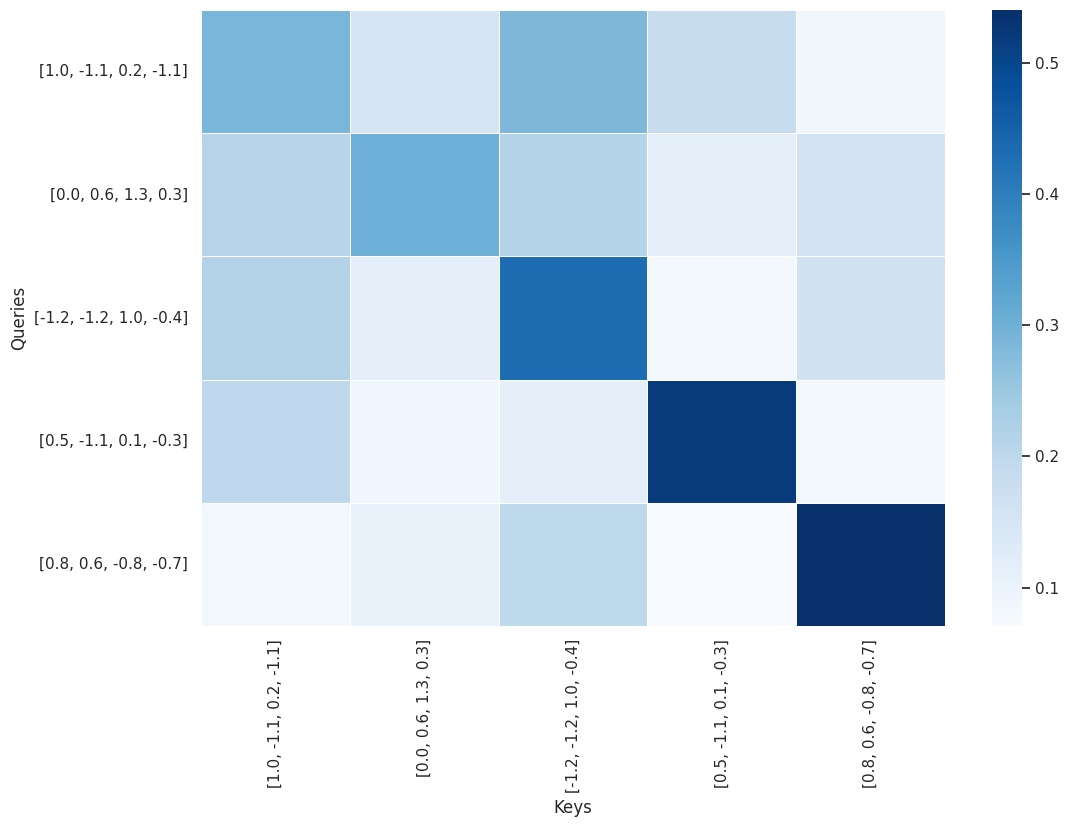

In [6]:
x = torch.randn(5, 4)
output, attn_weights = scaled_dot_product(q=x, k=x, v=x)

print(f"Output:\n{output}\n{output.shape}\n")
print(f"Attention weights:\n{attn_weights}\n{attn_weights.shape}\n")

plot_attention(
    attn_weights,
    [str([round(float(q__), 1) for q__ in q_]) for q_ in q],
    [str([round(float(q__), 1) for q__ in q_]) for q_ in q],
)

But then... that's all, "Attention is all you need"?

Well, no, **it's not enough with just attention**... We need learnable parameters somewhere!

Actually, the inputs of the SDPA need to be projected with a Linear layer. This way we can get different representations from the same input vectors. We do something like this:

<p align="center">
<img src="https://miro.medium.com/max/1578/1*_92bnsMJy8Bl539G4v93yg.gif" height="600px" alt="Self-Attention"/>
</p>

Here you can find an implementation of this "learnable" SDPA. Be aware that this class will not be used by the model we will implement, it's just an intermediate step we use now for didactic purposes.

In [7]:
class LearnableScaledDotProductAttention(nn.Module):
    def __init__(self, embed_dim):
        super(LearnableScaledDotProductAttention, self).__init__()
        self.proj_q = nn.Linear(embed_dim, embed_dim)
        self.proj_k = nn.Linear(embed_dim, embed_dim)
        self.proj_v = nn.Linear(embed_dim, embed_dim)

    def forward(self, q, k, v, attn_mask=None):
        q = self.proj_q(q)
        k = self.proj_k(k)
        v = self.proj_v(v)
        output, _ = scaled_dot_product(q, k, v, attn_mask)
        return output

Let's test that it can learn now, by trying to reconstruct the input tensor with self-attention:

In [8]:
sdpa = LearnableScaledDotProductAttention(embed_dim=4)
optimizer = optim.Adam(sdpa.parameters())

losses_sdpa = []
n_epochs = 10000
for i in range(n_epochs):
    optimizer.zero_grad()
    output = sdpa(q=x, k=x, v=x)    # Self-attention
    loss = F.mse_loss(output, x)    # Reconstruct the input
    loss.backward()
    optimizer.step()
    losses_sdpa.append(loss.item())
    if (i + 1) % 1000 == 0:
        print(f"Loss ({i+1}/{n_epochs}): {loss.item()}")


print(f"\nOutput:\n{output}\n")
print(f"Query:\n{x}\n")

Loss (1000/10000): 0.054977577179670334
Loss (2000/10000): 0.006850644946098328
Loss (3000/10000): 0.0015059959841892123
Loss (4000/10000): 3.2058007491286844e-05
Loss (5000/10000): 1.628517384233419e-05
Loss (6000/10000): 1.6202657207031734e-05
Loss (7000/10000): 1.6082934962469153e-05
Loss (8000/10000): 1.588809391250834e-05
Loss (9000/10000): 1.557200084789656e-05
Loss (10000/10000): 1.5064106264617294e-05

Output:
tensor([[-0.4854, -1.0989, -0.1696,  0.0289],
        [-0.2436,  0.0154, -0.6548, -0.6486],
        [-0.7529, -1.1211,  0.6830, -0.7505],
        [-0.0918, -0.4717,  0.0558,  1.5153],
        [-0.3616,  0.6892,  1.3728, -0.6328]], grad_fn=<MmBackward0>)

Query:
tensor([[-0.4979, -1.0956, -0.1715,  0.0311],
        [-0.2397,  0.0144, -0.6542, -0.6492],
        [-0.7449, -1.1232,  0.6842, -0.7519],
        [-0.0875, -0.4728,  0.0565,  1.5146],
        [-0.3654,  0.6903,  1.3723, -0.6321]])



Ok, looks good, we can train it. It's starting to make sense now, right?

### Multi-Head Attention

To further exploit this attention mechanism, the original paper introduced the Multi-Head Attention mechanism (MHA).

Instead of performing the attention mechanism just once, they found it benefitial to project the input multiple times into different "attention heads". This way, multiple attentions can be learned at the same time.

<p align="center">
<img src="https://paperswithcode.com/media/methods/multi-head-attention_l1A3G7a.png" height="400px" alt="Scaled Dot-Product Attention"/>
</p>

To combine the outputs of each head, they are concatenated and projected by a Linear transformation $W^O$, as defined by the following equation:

$$
MultiHead(Q, K, V ) = Concat(head_1, ..., head_h)W^O
$$
$$
where\ head_i = Attention(QW^Q_i, KW^K_i, V W^V_i)
$$

Note that $W^Q_i$, $W^K_i$, $W^V_i$ are the Linear projections we've seen in the previous section.

To better understand this, see the following illustration created by [Jay Alammar](https://jalammar.github.io/) for his famous blog post [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/):

<p align="center">
<img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" height="600px" alt="Self-Attention"/>
</p>

In [9]:
class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads):
        super(MultiheadAttention, self).__init__()
        assert embed_dim % num_heads == 0, \
            "Embedding dimension must be multiple of the number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.proj_q = nn.Linear(embed_dim, embed_dim)
        self.proj_k = nn.Linear(embed_dim, embed_dim)
        self.proj_v = nn.Linear(embed_dim, embed_dim)
        self.proj_o = nn.Linear(embed_dim, embed_dim)

        self.sdpa = scaled_dot_product

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.proj_q.weight)
        nn.init.xavier_uniform_(self.proj_k.weight)
        nn.init.xavier_uniform_(self.proj_v.weight)
        nn.init.xavier_uniform_(self.proj_o.weight)
        self.proj_q.bias.data.fill_(0)
        self.proj_k.bias.data.fill_(0)
        self.proj_v.bias.data.fill_(0)
        self.proj_o.bias.data.fill_(0)

    def forward(self, q, k, v, attn_mask=None):
        batch_size = q.size(1)

        q = self.proj_q(q)
        k = self.proj_k(k)
        v = self.proj_v(v)

        # TODO: Split the tensors into multiple heads
        #  T x B x embed_dim -> T x B x num_heads x head_dim
        q = q.reshape(q.size(0), batch_size, self.num_heads, self.head_dim)
        k = k.reshape(k.size(0), batch_size, self.num_heads, self.head_dim)
        v = v.reshape(v.size(0), batch_size, self.num_heads, self.head_dim)

        # The last two dimensions must be sequence length and the head dimension,
        # to make it work with the scaled dot-product function.
        # TODO: Rearrange the dimensions
        # T x B x num_heads x head_dim -> B x num_heads x T x head_dim
        q = q.permute(1, 2, 0, 3)
        k = k.permute(1, 2, 0, 3)
        v = v.permute(1, 2, 0, 3)

        # Apply the same mask to all the heads
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1)
            attn_mask = ~attn_mask
        else:
            attn_mask = None

        # TODO: Call the scaled dot-product function (remember to pass the mask!)
        attn_result = self.sdpa(q, k, v, attn_mask)

        # Check if `attn_result` contains one or two outputs.
        # If it contains two outputs (a tuple), unpack them into `output_heads` and `attn_w`.
        # Otherwise, it means no attention weights are provided.
        if isinstance(attn_result, tuple) and len(attn_result) == 2:
            output_heads, attn_w = attn_result
        else:
            output_heads, attn_w = attn_result, None

        # B x num_heads x T x head_dim -> T x B x num_heads x head_dim
        output_heads = output_heads.permute(2, 0, 1, 3)

        # T x B x num_heads x head_dim -> T x B x embed_dim
        output_cat = output_heads.reshape(-1, batch_size, self.embed_dim)
        output = self.proj_o(output_cat)

        return output, attn_w

Let's test the same dummy example than before, trying to reconstruct the input tensor with self-attention, this time with a MHA module:

In [10]:
mha = MultiheadAttention(embed_dim=4, num_heads=2)
optimizer = optim.Adam(mha.parameters())

losses_mha = []
n_epochs = 10000
for i in range(n_epochs):
    optimizer.zero_grad()
    output = mha(                # Self-attention
        q=x.unsqueeze(1),
        k=x.unsqueeze(1),
        v=x.unsqueeze(1)
    )[0].squeeze(1)
    loss = F.mse_loss(output, x) # Reconstruct input
    loss.backward()
    optimizer.step()
    losses_mha.append(loss.item())
    if (i + 1) % 1000 == 0:
        print(f"Loss ({i+1}/{n_epochs}): {loss.item()}")

print(f"\nOutput:\n{output}\n")
print(f"Query:\n{x}\n")

Loss (1000/10000): 0.0005772312870249152
Loss (2000/10000): 3.98791853513103e-05
Loss (3000/10000): 9.570225302013569e-06
Loss (4000/10000): 1.8716096974458196e-06
Loss (5000/10000): 1.667844742314628e-07
Loss (6000/10000): 3.5887937066547693e-09
Loss (7000/10000): 6.503265374130374e-12
Loss (8000/10000): 7.450290045812012e-15
Loss (9000/10000): 7.444739438908655e-15
Loss (10000/10000): 1.0736550876328833e-14

Output:
tensor([[-0.4979, -1.0956, -0.1715,  0.0311],
        [-0.2397,  0.0144, -0.6542, -0.6492],
        [-0.7449, -1.1232,  0.6842, -0.7519],
        [-0.0875, -0.4728,  0.0565,  1.5146],
        [-0.3654,  0.6903,  1.3723, -0.6321]], grad_fn=<SqueezeBackward1>)

Query:
tensor([[-0.4979, -1.0956, -0.1715,  0.0311],
        [-0.2397,  0.0144, -0.6542, -0.6492],
        [-0.7449, -1.1232,  0.6842, -0.7519],
        [-0.0875, -0.4728,  0.0565,  1.5146],
        [-0.3654,  0.6903,  1.3723, -0.6321]])



Ok, seems fine, it learns!

At this point, you already know all you need about attention in the Transformer :D Now, we need to know where to apply it.

But before looking again at the Transformer architecture, we need to make a small stop at the Positional Encoding.

### Positional Encoding

As you may know, RNNs are designed in a way that they know the ordering of the input tokens. This is very important when processing sequences such as text sentences.

However, when using Self-attention, there is no positional information used between the queries, keys and values. For this reason, the Transformer authors needed to give positional information to the model explicitly.

They simply decided to create an embedding table, with the following equation, which is summed to the embeddings of the inputs.

$$
PE_{(pos,2i) = sin(pos\ /\ 10000^{2i\ /\ d\_model})}
$$
$$
PE_{(pos,2i+1) = cos(pos\ /\ 10000^{2i\ /\ d\_model})}
$$
where $pos$ is the position and $i$ is the dimension.

The resulting positional embedding table is like this:
<p align="center">
<img src="https://d33wubrfki0l68.cloudfront.net/ef81ee3018af6ab6f23769031f8961afcdd67c68/3358f/img/transformer_architecture_positional_encoding/positional_encoding.png" height="350px" alt="Positional Encoding""/>
</p>

For more information about the positional encoding, check [this post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [11]:
class PositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_len=5000):
        """
        Args:
            embed_dim (int): Embedding dimensionality
            max_len (int): Maximum length of a sequence to expect
        """
        super(PositionalEncoding, self).__init__()

        # Create matrix of (T x embed_dim) representing the positional encoding
        # for max_len inputs
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)

        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x

### Encoder

Now the time has come to put everything together and build the Transformer Encoder!

This structure mainly consists of a stack of layers defined as below:

<p align="center">
<img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png" height="600px" alt="Transformer Encoder"/>
</p>

The [Layer Normalization](https://arxiv.org/abs/1607.06450) differs from Batch Normalization in that it works element-wise, as seen in the following figure:

<p align="center">
<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png" height="250px" alt="LayerNormalization"/>
</p>

The Feed Forward layers consist of a projection to a higher dimension (`ffn_dim`), a ReLU activation and another projection to the original dimension (`embed_dim`). They are defined by the following equation:

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

In [12]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, embed_dim, ffn_dim, num_heads, dropout=0.0):
        """
        Args:
            embed_dim (int): Embedding dimensionality (input, output & self-attention)
            ffn_dim (int): Inner dimensionality in the FFN
            num_heads (int): Number of heads of the multi-head attention block
            dropout (float): Dropout probability
        """
        super(TransformerEncoderLayer, self).__init__()

        self.self_attn = MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(ffn_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None, return_att=False):
        src_len, batch_size, _ = x.shape
        if mask is None:
            mask = torch.zeros(x.shape[1], x.shape[0]).bool().to(x.device)

        selfattn_mask = mask.unsqueeze(-2)

        # TODO: Self-Attention block
        selfattn_out, selfattn_w = self.self_attn(x, x, x, attn_mask=selfattn_mask)
        selfattn_out = self.dropout(selfattn_out)

        # TODO: Add + normalize block (1)
        x = self.norm1(x + selfattn_out)


        # TODO: FFN block
        ffn_out = self.ffn(x)

        ffn_out = self.dropout(ffn_out)

        # TODO: Add + normalize block (2)
        x = self.norm2(x + ffn_out)

        if return_att:
            return x, selfattn_w
        else:
            return x

In [13]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, embed_dim, ffn_dim, num_heads, vocab_size, dropout=0.0):
        super(TransformerEncoder, self).__init__()

        # Create an embedding table (T x B -> T x B x embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Create the positional encoding with the class defined before
        self.pos_enc = PositionalEncoding(embed_dim)

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, ffn_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None, return_att=False):
        x = self.embedding(x)
        x = self.pos_enc(x)

        selfattn_ws = []
        for l in self.layers:
            if return_att:
                x, selfattn_w = l(x, mask=mask, return_att=True)
                selfattn_ws.append(selfattn_w)
            else:
                x = l(x, mask=mask, return_att=False)

        if return_att:
            selfattn_ws = torch.stack(selfattn_ws, dim=1)
            return x, selfattn_ws
        else:
            return x

We have our Transformer Encoder implemented now! Let's try to do a forward pass:

In [14]:
transformer_encoder_cfg = {
    "num_layers": 6,
    "embed_dim": 512,
    "ffn_dim": 2048,
    "num_heads": 8,
    "vocab_size": 8000,
    "dropout": 0.1,
}

transformer_encoder = TransformerEncoder(**transformer_encoder_cfg)

src_batch_example = torch.randint(transformer_encoder_cfg['vocab_size'], (20, 4))

encoder_out, attn_ws = transformer_encoder(src_batch_example, return_att=True)

print(f"Encoder output: {encoder_out.shape}")
print(f"Self-Attention weights: {attn_ws.shape}")

Encoder output: torch.Size([20, 4, 512])
Self-Attention weights: torch.Size([4, 6, 8, 20, 20])


We have built a random batch ($T\ x\ B$) containing $B=4$ sentences of length $T=20$.

The output we get is ($T\ x\ B\ x\ embed\_dim$) and the self-attention weights are ($B\ x\ num\_layers\ x\ num\_heads\ x \ T\ x\ T$)

### Decoder

The Decoder has a similar structure than the Encoder but with two main differences.

First, in addition to self-attention, it needs to attend to the encoder outputs. With this purpose, it includes an Encoder-Decoder attention block between the Self-Attention and the FFN. This new module, also based on MHA, uses the encoder outputs (also known as `memory`) as the keys and values.

Secondly, the self-attention of the decoder cannot attend to "future" samples, because at inference time it works autorregresively. For this reason, we use a triangular mask in the self-attention.

<p align="center">
<img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" height="600px" alt="Transformer Encoder & Decoder"/>
</p>

In [15]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self, embed_dim, ffn_dim, num_heads, dropout=0.0):
        """
        Args:
            embed_dim (int): Embedding dimensionality (input, output & self-attention)
            ffn_dim (int): Inner dimensionality in the FFN
            num_heads (int): Number of heads of the multi-head attention block
            dropout (float): Dropout probability
        """
        super(TransformerDecoderLayer, self).__init__()

        self.self_attn = MultiheadAttention(embed_dim, num_heads)
        self.encdec_attn = MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_dim),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(ffn_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, mask=None, memory_mask=None, return_att=False):
        tgt_len, batch_size, _ = x.shape
        src_len, _, _ = memory.shape
        if mask is None:
            mask = torch.zeros(x.shape[1], x.shape[0])
            mask = mask.bool().to(x.device)
        if memory_mask is None:
            memory_mask = torch.zeros(memory.shape[1], memory.shape[0])
            memory_mask = memory_mask.bool().to(memory.device)


        subsequent_mask = torch.triu(torch.ones(batch_size, tgt_len, tgt_len), 1)
        subsequent_mask = subsequent_mask.bool().to(mask.device)
        selfattn_mask = subsequent_mask + mask.unsqueeze(-2)

        attn_mask = memory_mask.unsqueeze(-2)

        # TODO: Self-Attention block
        selfattn_out, selfattn_w = self.self_attn(x, x, x, attn_mask=selfattn_mask)

        selfattn_out = self.dropout(selfattn_out)

        # TODO: Add + normalize block (1)
        x = self.norm1(x + selfattn_out)

        # TODO: Encoder-Decoder Attention block
        attn_out, attn_w = self.encdec_attn(x, memory, memory, attn_mask=attn_mask)

        attn_out = self.dropout(attn_out)

        # TODO: Add + normalize block (2)
        x = self.norm2(x + attn_out)

        # TODO: FFN block
        ffn_out = self.ffn(x)

        ffn_out = self.dropout(ffn_out)

        # TODO: Add + normalize block (3)
        x =  self.norm3(x + ffn_out)

        if return_att:
            return x, selfattn_w, attn_w
        else:
            return x

In [16]:
class TransformerDecoder(nn.Module):

    def __init__(self, num_layers, embed_dim, ffn_dim, num_heads, vocab_size, dropout=0.0):
        super(TransformerDecoder, self).__init__()

        # Create an embedding table (T x B -> T x B x embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Create the positional encoding with the class defined before
        self.pos_enc = PositionalEncoding(embed_dim)

        self.layers = nn.ModuleList([
            TransformerDecoderLayer(embed_dim, ffn_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

        # Add a projection layer (T x B x embed_dim -> T x B x vocab_size)
        self.proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, memory, mask=None, memory_mask=None, return_att=False):
        x = self.embedding(x)
        x = self.pos_enc(x)

        selfattn_ws = []
        attn_ws = []
        for l in self.layers:
            if return_att:
                x, selfattn_w, attn_w = l(
                    x, memory, mask=mask, memory_mask=memory_mask, return_att=True
                )
                selfattn_ws.append(selfattn_w)
                attn_ws.append(attn_w)
            else:
                x = l(
                    x, memory, mask=mask, memory_mask=memory_mask, return_att=False
                )

        x = self.proj(x)
        x = F.log_softmax(x, dim=-1)

        if return_att:
            selfattn_ws = torch.stack(selfattn_ws, dim=1)
            attn_ws = torch.stack(attn_ws, dim=1)
            return x, selfattn_ws, attn_ws
        else:
            return x

And now we also have our Transformer Decoder implemented! Let's try to do a forward pass:

In [17]:
transformer_decoder_cfg = {
    "num_layers": 6,
    "embed_dim": 512,
    "ffn_dim": 2048,
    "num_heads": 8,
    "vocab_size": 8000,
    "dropout": 0.1,
}

transformer_decoder = TransformerDecoder(**transformer_decoder_cfg)

tgt_batch_example = torch.randint(transformer_decoder_cfg['vocab_size'], (15, 4))

decoder_out, selfattn_ws, attn_ws  = transformer_decoder(
    tgt_batch_example,
    memory=encoder_out,
    return_att=True
)

print(f"Decoder output: {decoder_out.shape}")
print(f"Self-Attention weights: {selfattn_ws.shape}")
print(f"Enc-Dec Attention weights: {attn_ws.shape}")

Decoder output: torch.Size([15, 4, 8000])
Self-Attention weights: torch.Size([4, 6, 8, 15, 15])
Enc-Dec Attention weights: torch.Size([4, 6, 8, 15, 20])


We have built a random target batch ($T_{tgt}\ x\ B$) containing $B=4$ sentences of length $T_{tgt}=15$, and we already had the output of the encoder fo size ($T_{src}\ x\ B\ x\ embed\_dim$).

The output we get from the decoder is ($T_{tgt}\ x\ B\ x\ vocab\_size$), the self-attention weights are ($B\ x\ num\_layers\ x\ num\_heads\ x \ T_{tgt}\ x\ T_{tgt}$), and the enc-dec attention weights are ($B\ x\ num\_layers\ x\ num\_heads\ x \ T_{tgt}\ x\ T_{src}$)

### Transformer

We already have all the components of the Transformer, it's time to put them all together!

Note that we will implement two methods to generate results, one to be used during training (whole sequence in parallel) and another to be used during inference (autorregresive generation). The first one is depicted in the original Transformer figure, while the second can be seen in the animation below:



<p align="center">
<img src="https://paperswithcode.com/media/methods/new_ModalNet-21.jpg" height="600px" alt="Transformer"/>
</p>

<p align="center">
<img src="https://jalammar.github.io/images/t/transformer_decoding_2.gif" height="600px" alt="Autorregressive decoding"/>
</p>

In [18]:
class Transformer(nn.Module):
    def __init__(self, encoder_config, decoder_config):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(**encoder_config)
        self.decoder = TransformerDecoder(**decoder_config)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """ Forward method

        Method used at training time, when the target is known. The target tensor
        passed to the decoder is shifted to the right (starting with BOS
        symbol). Then, the output of the decoder starts directly with the first
        token of the sentence.
        """

        # TODO: Compute the encoder output
        encoder_out = self.encoder(
        x= src,
        mask= src_mask
        )

        # TODO: Compute the decoder output
        decoder_out = self.decoder(
        x= tgt,
        memory= encoder_out,
        mask= tgt_mask,
        memory_mask=src_mask
        )

        return decoder_out

    def generate(self, src, src_mask=None, bos_idx=0, max_len=50):
        """ Generate method

        Method used at inference time, when the target is unknown. It
        iteratively passes to the decoder the sequence generated so far
        and appends the new token to the input again. It uses a Greedy
        decoding (argmax).
        """

        # TODO: Compute the encoder output
        encoder_out = self.encoder(
        x= src,
        mask= src_mask
        )

        output = torch.LongTensor([bos_idx])\
                    .expand(1, encoder_out.size(1)).to(src.device)
        for i in range(max_len):
            # TODO: Get the new token
            new_token = self.decoder(
                x=output,
                memory=encoder_out,
                memory_mask=src_mask
            )[-1].argmax(-1)

            output = torch.cat([output, new_token.unsqueeze(0)], dim=0)

        return output

In [19]:
transformer = Transformer(transformer_encoder_cfg, transformer_decoder_cfg)

In [20]:
transformer(src_batch_example, tgt_batch_example).shape

torch.Size([15, 4, 8000])

You got it! You have built your own Transformer!

**NOTE: Most of the modules we've implemented are available in `torch.nn`, you don't need to copy all this code the next time you want to use a Transformer ;D**

## Training your new Transformer

We will train our Transformer on a simple task, consisting of translating from numbers to their English written form.

In [21]:
!pip install -q git+https://github.com/gegallego/seq2seq-numbers-dataset.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.1 MB/s eta 0:00:00


In [22]:
from seq2seq_numbers_dataset import generate_dataset_pytorch, Seq2SeqNumbersCollater

numbers_dataset = generate_dataset_pytorch()

# Downsample the dataset to reduce training time (remove for better performance)
numbers_dataset['train'].src_sents = numbers_dataset['train'].src_sents[:25000]
numbers_dataset['train'].tgt_sents = numbers_dataset['train'].tgt_sents[:25000]

# Downsample the dataset to reduce evaluation time
numbers_dataset['test'].src_sents = numbers_dataset['test'].src_sents[:7500]
numbers_dataset['test'].tgt_sents = numbers_dataset['test'].tgt_sents[:7500]

collater = Seq2SeqNumbersCollater(
    numbers_dataset['train'].src_dict,
    numbers_dataset['train'].tgt_dict,
)

In [23]:
def train(model, dataloader, lr, device, log_interval=50):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = F.nll_loss

    model.to(device)
    model.train()

    print("Training model...")
    torch.cuda.synchronize()
    ini = time.time()

    loss_avg = 0
    for i, (src, tgt) in enumerate(dataloader):
        src = {k: v.to(device) for k, v in src.items()}
        tgt = {k: v.to(device) for k, v in tgt.items()}

        optimizer.zero_grad()

        output = model(
            src['ids'],
            tgt['ids'][:-1],
            src['padding_mask'],
            tgt['padding_mask'][:, :-1],
        )

        loss = criterion(
            output.reshape(-1, output.size(-1)),
            tgt['ids'][1:].flatten()
        )
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()
        if (i+1) % log_interval == 0:
            loss_avg /= log_interval
            print(f"{i+1}/{len(dataloader)}\tLoss: {loss_avg}")

    torch.cuda.synchronize()
    end = time.time()
    secs = round(end - ini, 2)
    print(f"Done training (took {secs} seconds)")

    return model


def test(model, dataloader, device, log_interval=50):
    model.eval()

    print("\nTesting model...")
    torch.cuda.synchronize()
    ini = time.time()

    n_correct = 0
    n_total = 0
    for i, (src, tgt) in enumerate(dataloader):
        src = {k: v.to(device) for k, v in src.items()}
        tgt = {k: v.to(device) for k, v in tgt.items()}

        output = model.generate(
            src['ids'],
            src_mask=src['padding_mask'],
            bos_idx=numbers_dataset['test'].tgt_dict.bos_idx(),
        )
        output = output[:tgt['ids'].size(0)]

        n_correct += torch.eq(tgt['ids'], output).sum().item()
        n_total += tgt['ids'].numel()
        if (i+1) % log_interval == 0:
            print(f"{i+1}/{len(dataloader)}")

    acc = round(100 * n_correct / n_total, 2)

    torch.cuda.synchronize()
    end = time.time()
    secs = round(end - ini, 2)
    print(f"Test Accuracy: {acc}% (took {secs} seconds)")

In [24]:
batch_size = 32
lr = 5e-4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

numbers_loader_train = DataLoader(
    numbers_dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collater,
)

src_dict = numbers_dataset['train'].src_dict
tgt_dict = numbers_dataset['train'].tgt_dict

transformer_encoder_cfg = {
    "num_layers": 3,
    "embed_dim": 256,
    "ffn_dim": 1024,
    "num_heads": 4,
    "vocab_size": len(src_dict),
    "dropout": 0.1,
}
transformer_decoder_cfg = {
    "num_layers": 3,
    "embed_dim": 256,
    "ffn_dim": 1024,
    "num_heads": 4,
    "vocab_size": len(tgt_dict),
    "dropout": 0.1,
}
model = Transformer(transformer_encoder_cfg, transformer_decoder_cfg)

### Training

In [25]:
model = train(
    model,
    numbers_loader_train,
    lr,
    device=device
)

Training model...
50/782	Loss: 1.7802931010723113
100/782	Loss: 0.7431081711053849
150/782	Loss: 0.5834947577691078
200/782	Loss: 0.5128663999866963
250/782	Loss: 0.3859839318653574
300/782	Loss: 0.24253641342810917
350/782	Loss: 0.1852025184583052
400/782	Loss: 0.13092643056025383
450/782	Loss: 0.09966182970180318
500/782	Loss: 0.07069092889888569
550/782	Loss: 0.070102410073134
600/782	Loss: 0.06118158149828618
650/782	Loss: 0.052314801419399204
700/782	Loss: 0.0352473734747295
750/782	Loss: 0.03268404143091226
Done training (took 21.61 seconds)


### Testing

In [26]:
batch_size_test = 128

numbers_loader_test = DataLoader(
    numbers_dataset['test'],
    batch_size=batch_size_test,
    shuffle=False,
    collate_fn=collater,
)

test(model, numbers_loader_test, device)


Testing model...
50/59
Test Accuracy: 98.24% (took 28.06 seconds)


### Inference

Check how the model works by selecting any number.

In [28]:
#@title  { run: "auto", vertical-output: true }
#@title  { run: "auto" }
#@markdown Select a number to pass to the model:
input_num = 43669.9 #@param {type:"slider", min:-100000, max:100000, step:0.1}

src_dict = numbers_dataset['train'].src_dict
tgt_dict = numbers_dataset['train'].tgt_dict

input_num_str = "{:,.2f}".format(input_num)
input_num_enc = torch.LongTensor(
    src_dict.encode(input_num_str)
).unsqueeze(-1).to(device)

output_word_enc = model.generate(
    input_num_enc,
    bos_idx=tgt_dict.bos_idx()
)

output_word = tgt_dict.decode(
    output_word_enc.flatten().tolist()
)

print(f"Input: {input_num_str}")
print(f"Output: {output_word}")

Input: 43,669.90
Output: forty-three thousand, six hundred and sixty-nine point nine


### Attention visualization

Analyze the attention weights with the following tool. Are they how you expected?

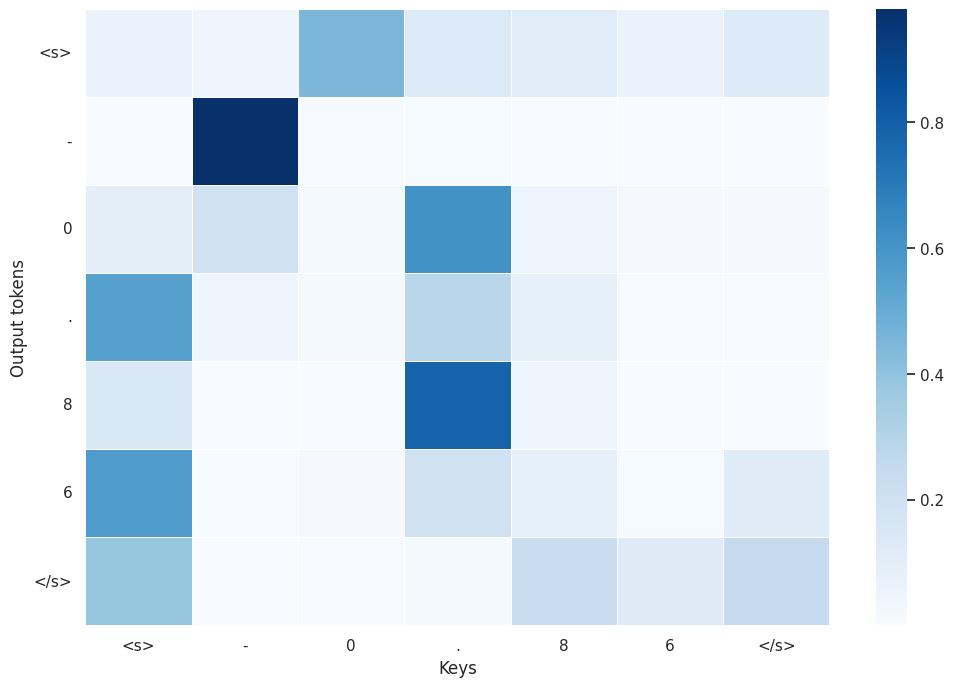

In [32]:
#@title  { run: "auto", vertical-output: true }
#@title  { run: "auto" }
#@title  { run: "auto", vertical-output: true }
#@markdown Select a sample from the dataset:
dataset_index =   1#@param {type:"integer"}
#@markdown Select the attention to visualize:
attention = "encoder self-attention" #@param ["encoder-decoder attention", "encoder self-attention", "decoder self-attention"]
#@markdown Select the layer:
layer = "2" #@param ["3", "2", "1"]
#@markdown Select a head (or average them):
head = "1" #@param ["avg", "1", "2", "3", "4"]

src, tgt = collater(
    [numbers_dataset["train"][dataset_index]]
)
src = {k: v.to(device) for k, v in src.items()}
tgt = {k: v.to(device) for k, v in tgt.items()}

src_dict = numbers_dataset['train'].src_dict
tgt_dict = numbers_dataset['train'].tgt_dict

enc_output, enc_selfattn = model.encoder(
    src['ids'],
    src['padding_mask'],
    return_att=True,
)

dec_output, dec_selfattn, encdec_attn = model.decoder(
    tgt['ids'][:-1],
    enc_output,
    tgt['padding_mask'][:, :-1],
    src['padding_mask'],
    return_att=True,
)

if attention=="encoder-decoder attention":
    attention_w = encdec_attn
    queries = [tgt_dict[i] for i in dec_output.argmax(-1)[:,0].tolist()]
    keys = [src_dict[i] for i in src['ids'][:, 0].tolist()]
    ytitle = "Output tokens"


elif attention=="encoder self-attention":
    attention_w = enc_selfattn
    queries = [src_dict[i] for i in src['ids'][:, 0].tolist()]
    keys = [src_dict[i] for i in src['ids'][:, 0].tolist()]

elif attention=="decoder self-attention":
    attention_w = dec_selfattn
    queries = [tgt_dict[i] for i in dec_output.argmax(-1)[:,0].tolist()]
    keys = [tgt_dict[i] for i in tgt['ids'][:-1, 0].tolist()]
    ytitle = "Output tokens"

if head == "avg":
    attention_w = attention_w[0][int(layer)-1].mean(0)
else:
    attention_w = attention_w[0][int(layer)-1][int(head)-1]

plot_attention(
    attention_w,
    queries,
    keys,
    ytitle=ytitle,
)


## Extra: Variations of your Transformer

Congratulations on implementing and successfully training your own Transformer! In this section, we will explore ways to extend and modify its functionality by introducing variations commonly used in advanced Transformer designs. These exercises will give you hands-on experience with some of the latest innovations in Transformer models. Specifically, we will work on:
- **Learnable Positional Encodings**: Replace the fixed sinusoidal positional encodings with learnable embeddings, allowing the model to adapt positional information to the specific dataset.
- **Optimized Scaled Dot-Product Attention**: Introduce more efficient implementations of attention mechanisms to reduce computational overhead and memory usage.
- **Multi-Query Attention**: Experiment with a variant of Multi-Head Attention that reduces the number of keys and values, improving efficiency without significantly impacting performance.

To implement these modifications, we will use a technique called [monkey patching](https://en.wikipedia.org/wiki/Monkey_patch). This allows us to replace or modify specific parts of your existing implementation at runtime. While this is not the most robust or maintainable approach for production code, it enables rapid prototyping by avoiding extensive rewrites of earlier sections.

Please note that monkey patching should be used with caution in real-world projects. In practice, a cleaner approach would involve subclassing or re-implementing components to maintain modularity and code clarity.

### Learnable Positional Encoding

In this section, we will implement Learnable Positional Encodings, where the positional information is represented as learnable parameters. This approach allows the model to optimize positional embeddings during training, potentially improving performance on tasks with unique positional patterns.

Create an embedding table (`nn.Embedding`) to represent positional encoding up to `max_len` inputs. During the forward pass, you'll need to encode positions with it, and sum the resulting embeddings to the input.

In [ ]:
class LearnablePositionalEncoding(nn.Module):

    def __init__(self, embed_dim, max_len=512):
        """
        Args:
            embed_dim (int): Embedding dimensionality
            max_len (int): Maximum length of a sequence to expect
        """
        super(LearnablePositionalEncoding, self).__init__()

        # TODO: Create the embedding table
        self.pe = nn.Embedding(
        num_embeddings=...
        embedding_dim=...
        )

    def forward(self, x):
        seq_len, batch_size, _ = x.shape

        # TODO: Prepare a tensor containing the position of each element in the sequence.
        # Consider that `x` is (T x B x D), and that you need to generate (T x B).
        # Hint: You can use the `torch.arange` function.
        positions = ...

        positions = positions.to(x.device)

        # T x B -> T x B  x embed_dim
        pos_emb = self.pe(positions)

        return x + pos_emb

Let's instantiate our Transformer class, and apply a monkey patch to substitute the original sinusoidal positional encoding by the new one.

In [ ]:
model = Transformer(transformer_encoder_cfg, transformer_decoder_cfg)

model.encoder.pos_enc = LearnablePositionalEncoding(transformer_encoder_cfg["embed_dim"])
model.decoder.pos_enc = LearnablePositionalEncoding(transformer_decoder_cfg["embed_dim"])

In [ ]:
# Reinitialize the dataloaders
numbers_loader_train = DataLoader(
    numbers_dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collater,
)
numbers_loader_test = DataLoader(
    numbers_dataset['test'],
    batch_size=batch_size_test,
    shuffle=False,
    collate_fn=collater,
)

# Train and test the model again
model = train(
    model,
    numbers_loader_train,
    lr,
    device=device
)
test(model, numbers_loader_test, device)

Training model...
50/782	Loss: 1.645468418598175
100/782	Loss: 0.6891056174993514
150/782	Loss: 0.5277283844847679
200/782	Loss: 0.40945316802958487
250/782	Loss: 0.24408848999967175
300/782	Loss: 0.11298036471884051
350/782	Loss: 0.05851811827885719
400/782	Loss: 0.03975599212679617
450/782	Loss: 0.025888076378054094
500/782	Loss: 0.01771770639997019
550/782	Loss: 0.0165758650728874
600/782	Loss: 0.023298216808545217
650/782	Loss: 0.021318041734620086
700/782	Loss: 0.025459831059281512
750/782	Loss: 0.016623385724431367
Done training (took 21.67 seconds)

Testing model...
50/59
Test Accuracy: 99.49% (took 32.28 seconds)


If your model achieved similar accuracy to the previous implementation, congratulations, it worked! Since we are working on a relatively simple task, there was not much room for improvement. However, you have now gained a deeper understanding of how learnable positional encodings work and how they can serve as an alternative to fixed sinusoidal encodings.

### Optimized Scaled Dot-Product Attention

In our Transformer, we implemented the scaled dot-product attention (SDPA) with a custom function. While functional, this implementation may not take full advantage of the hardware acceleration and optimizations available in PyTorch's native implementation, [`F.scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html).

In this section, we will replace all attention computations with PyTorch's native function. This optimized implementation not only improves computational efficiency but also allows seamless switching to advanced backends like FlashAttention, significantly enhancing speed and memory usage for large models and long sequences.

As in the previous exercise, we will integrate the optimized function using monkey patching to avoid modifying other parts of our Transformer. To do so, override the `sdpa` attribute in every `MultiHeadAttention`, which defines the function to be used, by `F.scaled_dot_product_attention`.

In [ ]:
model = Transformer(transformer_encoder_cfg, transformer_decoder_cfg)

# TODO: Override `sdpa` in every MultiHeadAttention to use PyTorch's native function
for l in model.encoder.layers:
    l.self_attn.sdpa = ...
for l in ...
    ...
    ...

In [ ]:
numbers_loader_train = DataLoader(
    numbers_dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collater,
)
numbers_loader_test = DataLoader(
    numbers_dataset['test'],
    batch_size=batch_size_test,
    shuffle=False,
    collate_fn=collater,
)

with nn.attention.sdpa_kernel(nn.attention.SDPBackend.EFFICIENT_ATTENTION):
    model = train(
        model,
        numbers_loader_train,
        lr,
        device=device
    )
    test(model, numbers_loader_test, device)

Training model...
50/782	Loss: 1.5385542452335357
100/782	Loss: 0.694234370470047
150/782	Loss: 0.5542442625617982
200/782	Loss: 0.46777092064590453
250/782	Loss: 0.299673743574852
300/782	Loss: 0.1910045094793843
350/782	Loss: 0.13370132704080306
400/782	Loss: 0.12089641397386813
450/782	Loss: 0.08667732842369677
500/782	Loss: 0.05331401755513823
550/782	Loss: 0.06454805527728837
600/782	Loss: 0.05230330449732185
650/782	Loss: 0.05728112726606767
700/782	Loss: 0.0475012090442971
750/782	Loss: 0.03513235522138754
Done training (took 19.83 seconds)

Testing model...
50/59
Test Accuracy: 98.15% (took 30.33 seconds)


You may have noticed that training and evaluation were slightly faster with the optimized implementation (maybe just a bit?). However, the true benefits of efficient attention mechanisms become more apparent when working with long sequences, which is not the case for our very simple task.

Additionally, we used the `EFFICIENT_ATTENTION` backend for this exercise. You can find a full list of available backends and their descriptions [here](https://pytorch.org/docs/stable/generated/torch.nn.attention.SDPBackend.html). Unfortunately, we could not use the more advanced `FLASH_ATTENTION` backend due to hardware limitations on the free tier of Google Colab, as it requires more modern GPUs. If you have access to compatible hardware, consider experimenting with `FLASH_ATTENTION` to explore its significant performance advantages.

### Multi-Query Attention

Multi-Head Attention is one of the key innovations of the Transformer architecture, allowing the model to focus on multiple aspects of the input simultaneously. However, as the number of attention heads increases, the computational and memory costs grow significantly.

Multi-Query Attention provides a more efficient alternative by sharing a single set of key-value pairs across all attention heads while keeping separate query projections for each head. This approach reduces the computational overhead, particularly in tasks with long sequences, without sacrificing much of the flexibility of traditional multi-head attention.

In this section, you will implement Multi-Query Attention by modifying the previously defined Multi-Head Attention class.

Copy the code from the `MultiheadAttention` class and modify it accordingly to do Multi-Query Attention.

In [ ]:
class MultiQueryAttention(nn.Module):

    def __init__(self, embed_dim, num_heads):
        super(MultiQueryAttention, self).__init__()
        # TODO
        assert embed_dim % num_heads == 0, \
            "Embedding dimension must be multiple of the number of heads."
        self.embed_dim = embed_dim ## ...
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.proj_q = nn.Linear(embed_dim, embed_dim)
        self.proj_k = nn.Linear(embed_dim, self.head_dim)
        self.proj_v = nn.Linear(embed_dim, self.head_dim)
        self.proj_o = nn.Linear(embed_dim, embed_dim)
        self.sdpa = scaled_dot_product
        self._reset_parameters()

    def _reset_parameters(self):
        # TODO
        nn.init.xavier_uniform_(self.proj_q.weight) ## ...
        nn.init.xavier_uniform_(self.proj_k.weight)
        nn.init.xavier_uniform_(self.proj_v.weight)
        nn.init.xavier_uniform_(self.proj_o.weight)
        self.proj_q.bias.data.fill_(0)
        self.proj_k.bias.data.fill_(0)
        self.proj_v.bias.data.fill_(0)
        self.proj_o.bias.data.fill_(0)

    def forward(self, q, k, v, attn_mask=None):
        # TODO
        batch_size = q.size(1) ## ...
        q = self.proj_q(q)
        k = self.proj_k(k)
        v = self.proj_v(v)
        q = q.reshape(-1, batch_size, self.num_heads, self.head_dim)
        k = k.reshape(-1, batch_size, 1, self.head_dim)
        v = v.reshape(-1, batch_size, 1, self.head_dim)
        q = q.permute(1, 2, 0, 3)
        k = k.permute(1, 2, 0, 3)
        v = v.permute(1, 2, 0, 3)
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1)
            attn_mask = ~attn_mask
        else:
            attn_mask = None
        attn_result = self.sdpa(q, k, v, attn_mask)
        if isinstance(attn_result, tuple) and len(attn_result) == 2:
            output_heads, attn_w = attn_result
        else:
            output_heads, attn_w = attn_result, None
        output_heads = output_heads.permute(2, 0, 1, 3)
        output_cat = output_heads.reshape(-1, batch_size, self.embed_dim)
        output = self.proj_o(output_cat)
        return output, attn_w

Similarly than before, let's test it with the same dummy example, trying to reconstruct the input tensor with self-attention:

In [ ]:
x = torch.randn(5, 4)

mha = MultiQueryAttention(embed_dim=4, num_heads=2)
optimizer = optim.Adam(mha.parameters())

losses_mha = []
n_epochs = 10000
for i in range(n_epochs):
    optimizer.zero_grad()
    output = mha(                # Self-attention
        q=x.unsqueeze(1),
        k=x.unsqueeze(1),
        v=x.unsqueeze(1)
    )[0].squeeze(1)
    loss = F.mse_loss(output, x) # Reconstruct input
    loss.backward()
    optimizer.step()
    losses_mha.append(loss.item())
    if (i + 1) % 1000 == 0:
        print(f"Loss ({i+1}/{n_epochs}): {loss.item()}")

print(f"\nOutput:\n{output}\n")
print(f"Query:\n{x}\n")

Loss (1000/10000): 0.012391733936965466
Loss (2000/10000): 0.0025461206678301096
Loss (3000/10000): 0.0014150055358186364
Loss (4000/10000): 0.0005614683614112437
Loss (5000/10000): 1.172564134321874e-05
Loss (6000/10000): 1.4482102184132373e-09
Loss (7000/10000): 7.930947700874116e-14
Loss (8000/10000): 2.4920342888866062e-14
Loss (9000/10000): 1.867405119426735e-09
Loss (10000/10000): 9.798852840248173e-10

Output:
tensor([[ 0.3740,  0.7271, -0.5255,  0.0103],
        [ 0.3353,  2.2325,  1.4741, -0.5971],
        [-0.2868, -0.6310,  0.0295,  0.2965],
        [-0.0812, -1.0214, -0.3847, -0.2070],
        [ 0.8054,  0.7689, -0.9654,  0.0737]], grad_fn=<SqueezeBackward1>)

Query:
tensor([[ 0.3740,  0.7271, -0.5255,  0.0102],
        [ 0.3353,  2.2325,  1.4741, -0.5971],
        [-0.2868, -0.6310,  0.0295,  0.2965],
        [-0.0812, -1.0214, -0.3847, -0.2071],
        [ 0.8054,  0.7689, -0.9654,  0.0736]])



Let's instantiate our Transformer class, and apply a monkey patch to substitute the original `MultiheadAttention` with the new `MultiQueryAttention` class.

In [ ]:
model = Transformer(transformer_encoder_cfg, transformer_decoder_cfg)

for l in model.encoder.layers:
    l.self_attn = MultiQueryAttention(
        embed_dim=l.self_attn.embed_dim,
        num_heads=l.self_attn.num_heads,
    )

for l in model.decoder.layers:
    l.self_attn = MultiQueryAttention(
        embed_dim=l.self_attn.embed_dim,
        num_heads=l.self_attn.num_heads,
    )
    l.encdec_attn = MultiQueryAttention(
        embed_dim=l.encdec_attn.embed_dim,
        num_heads=l.encdec_attn.num_heads,
    )

In [ ]:
numbers_loader_train = DataLoader(
    numbers_dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collater,
)
numbers_loader_test = DataLoader(
    numbers_dataset['test'],
    batch_size=batch_size_test,
    shuffle=False,
    collate_fn=collater,
)

model = train(
    model,
    numbers_loader_train,
    lr,
    device=device
)
test(model, numbers_loader_test, device)

Training model...
50/782	Loss: 1.9800407481193543
100/782	Loss: 0.8014287630558014
150/782	Loss: 0.610022979338646
200/782	Loss: 0.5409304813019371
250/782	Loss: 0.5028662246773083
300/782	Loss: 0.47113327952684847
350/782	Loss: 0.4417876253073338
400/782	Loss: 0.3743318801115849
450/782	Loss: 0.27902203924455427
500/782	Loss: 0.20733406278034014
550/782	Loss: 0.16641480085900226
600/782	Loss: 0.11467252127481516
650/782	Loss: 0.09292379696213265
700/782	Loss: 0.07429714879473906
750/782	Loss: 0.08791112102688965
Done training (took 21.94 seconds)

Testing model...
50/59
Test Accuracy: 94.48% (took 29.79 seconds)


You may not notice substantial differences in performance and efficiency when running this exercise, as the true advantages of Multi-Query Attention become evident with much longer sequences. However, if you've successfully implemented this variation, congratulations! You've taken an important step towards understanding how to adapt and optimize the core mechanisms of the Transformer architecture.

By completing this notebook, you've gained hands-on experience building a Transformer from scratch, exploring key architectural components, and implementing advanced variations such as learnable positional encodings, different attention backends, and Multi-Query Attention. These skills will serve as a solid foundation for experimenting with more sophisticated Transformer models and tailoring them to specific tasks.

## References

The images are from:
- https://jalammar.github.io/illustrated-transformer/
- https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
- https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://paperswithcode.com/method/layer-normalization
- https://paperswithcode.com/media/methods/multi-head-attention_l1A3G7a.png
- https://paperswithcode.com/method/scaled

The code is partially inspired by:
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
- https://nlp.seas.harvard.edu/2018/04/03/attention.html